## Stuff from class

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import warnings 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")

In [2]:
all_data = pd.read_csv("C://Users//HOME//Downloads//forest_dataset.csv")

In [3]:
all_data.shape

(10000, 55)

In [4]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

In [5]:
labels.shape, feature_matrix.shape

((10000,), (10000, 54))

In [6]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [7]:
clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
accuracy_score(clf.predict(test_feature_matrix), test_labels)

0.7365

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [8]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_neighbors" : range(1,11) ,
    "metric" : ['manhattan', 'euclidean'],
    "weights" : ['uniform', 'distance']

}

clf_grid = GridSearchCV(clf, params, cv=3, scoring='accuracy', n_jobs=-1, verbose = 3)
clf_grid.fit(train_feature_matrix, train_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

Let's output the best parameters

In [9]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [10]:
optimal_clf = clf_grid.best_estimator_
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

In [11]:
accuracy_score(optimal_clf.predict(test_feature_matrix), test_labels)

0.785

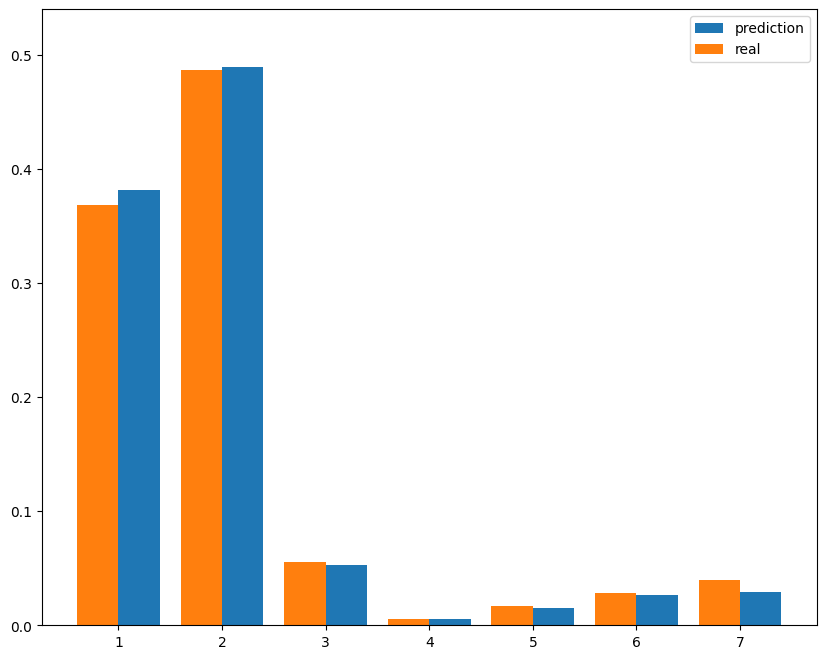

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [32]:
for average in ["macro", "micro"]:
    print(f"The result of roc_auc with one vs rest strategy and {average} average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovr", average=average))
print(f"The result of roc_auc with one vs one strategy and macro average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovo")) #micro average with one vs one is not possible

The result of roc_auc with one vs rest strategy and macro average is  0.9057501676949595
The result of roc_auc with one vs rest strategy and micro average is  0.9556655416666667
The result of roc_auc with one vs one strategy and macro average is  0.8977125968267149


In [34]:
np.unique(test_labels)

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

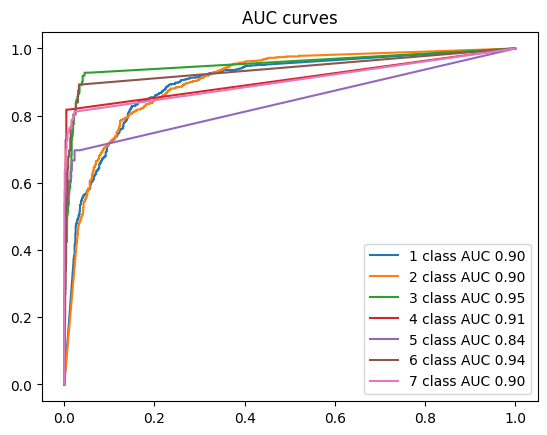

In [60]:
#going to plot according to one vs rest
for i in range(1,8):
    fpr, tpr, thr = roc_curve(test_labels==i, pred_prob[:,i-1])
    plt.plot(fpr, tpr, label=f"{i} class AUC {roc_auc_score(test_labels==i, pred_prob[:,i-1]):.2f}")
plt.title("AUC curves")
plt.legend()
plt.show()

The model has high quality due to metrics
Pros:
1) Simple
2) Fast train
3) Good for dense data
Cons:
1) Slow preidicting
2) Bad for not tight
3) Is very sensitive ti k parameter

### Comparison with log regression

In [67]:
clf = LogisticRegression(solver='saga')

param_grid = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2'],
}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(train_feature_matrix, train_labels)
clf_logregr = search.best_estimator_

In [73]:
search.best_params_
pred_prob = clf_logregr.predict_proba(test_feature_matrix)

In [74]:
accuracy_score(clf_logregr.predict(test_feature_matrix), test_labels)

0.624

In [75]:
for average in ["macro", "micro"]:
    print(f"The result of roc_auc with one vs rest strategy and {average} average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovr", average=average))
print(f"The result of roc_auc with one vs one strategy and macro average is ", 
        roc_auc_score(test_labels, pred_prob, multi_class="ovo")) #micro average with one vs one is not possible

The result of roc_auc with one vs rest strategy and macro average is  0.8194793702990054
The result of roc_auc with one vs rest strategy and micro average is  0.9248601666666666
The result of roc_auc with one vs one strategy and macro average is  0.7670678472290589


As we see Knn is better due to metrics, but lets answer why?

In [77]:
tSNE = TSNE(2)
data = tSNE.fit_transform(test_feature_matrix)

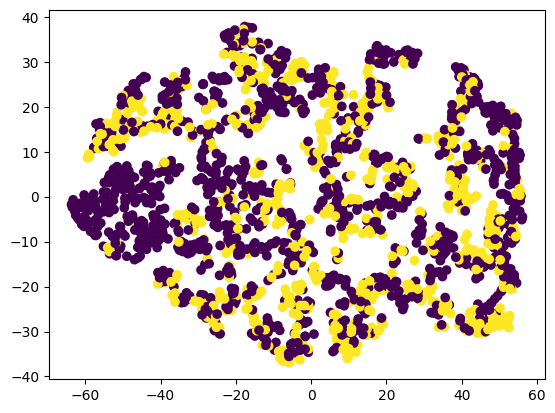

In [82]:
plt.scatter(data[:,0], data[:,1], c = test_labels==1)
plt.show()

As we see, for example for the 1 label, it can't be devided with other labels by hyperplane, but we see, that data looks like clouds of the two colors